### Import libraries

In [4]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, make_scorer, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC, LinearSVC
from transformers import AutoTokenizer, AutoModel
from collections import Counter
from typing import Union
from xgboost import XGBClassifier, XGBRegressor
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib as jb
import numpy as np
import pymorphy3
import optuna
import string
import torch
import nltk

In [5]:
Int = Union[int, np.integer]
Real = Union[float, np.floating, int, np.integer]

### Import data

In [6]:
fake_data = pd.read_csv("./data/fake_data.csv", header=0)
real_data = pd.read_csv("./data/data.csv", header=0)

data = pd.concat([real_data, fake_data], axis=0, ignore_index=True)

del real_data, fake_data

data

,description,classes,duration
0,Разметить данные,Работа,20160
1,Сделать ТАУ,Образование,60
2,Сходить в магазин за продуктами,Покупки,45
3,Сходить в магазин,Покупки,120
4,Приготовить обед,Быт,90
...,...,...,...
2814,Записаться на йогу,Спорт,20
2815,Сходить в океанариум,Развлечения,120
2816,Купить новый шарф,Покупки,30
2817,Погулять в парке с семьей,"Отношения, Развлечения",90


### Preprocess description column

In [7]:
def transform_descr(x: list) -> str:
    words = word_tokenize(x, language="russian")
    meaningful_words = [word for word in words if not word in russian_stopwords]
    formed_words = [morph.parse(word)[0].normal_form for word in meaningful_words]

    return " ".join(formed_words)

In [8]:
translator = str.maketrans('', '', string.punctuation + string.digits)
russian_stopwords = stopwords.words("russian")
morph = pymorphy3.MorphAnalyzer()

data["description"] = data["description"].str.lower().str.translate(translator)
data["description"] = data["description"].apply(func=lambda x: transform_descr(x))

data

,description,classes,duration
0,разметить дать,Работа,20160
1,сделать тау,Образование,60
2,сходить магазин продукт,Покупки,45
3,сходить магазин,Покупки,120
4,приготовить обед,Быт,90
...,...,...,...
2814,записаться йог,Спорт,20
2815,сходить океанариум,Развлечения,120
2816,купить новый шарф,Покупки,30
2817,погулять парка семья,"Отношения, Развлечения",90


# Multi-label classification

### X_train / X_valid / X_test split

In [9]:
class RatioValidator:
    def __set_name__(self, owner, name):
        self.name = "_" + name

    def __set__(self, instance, value):
        if not isinstance(value, (float, np.floating, int, np.integer)):
            raise TypeError(f"{self.name} must be a real number")
        elif not (0 <= value <= 1):
            raise ValueError(f"{self.name} must be between 0 and 1")

        setattr(instance, self.name, value)

    def __get__(self, instance, owner):
        return getattr(instance, self.name, None)


class StratifiedMultiLabelSplitter:
    """The class that divides a sample into 3 parts. To split into 2, set parameter 'valid_size' as 0.0.\n\n

       __init__:\n
       valid_size [float | np.floating | int | np.integer]: Real number, that shows the proportion of validation set. It requires being between 0 and 1\n
       test_size [float | np.floating | int | np.integer]: Real number, that shows the proportion of test set. It requires being between 0 and 1\n
       random_state [int | np.integer]: An integer that, controls the shuffling applied to the data before applying the split\n\n

       __call__:\n
       X [np.ndarray | pd.DataFrame]: Features\n
       y [np.ndarray | pd.Series]: Target collection. They are supposed to be represented as arrays of possible classes"""

    valid_size, test_size = RatioValidator(), RatioValidator()

    def __init__(self, valid_size: Real, test_size: Real, random_state: Int = 21):
        self.random_state = random_state
        self.test_size = test_size
        self.valid_size = valid_size

        if self.test_size + self.valid_size > 1:
            raise ValueError("test_size + valid_size must be <= 1")

    def __call__(self, x: pd.DataFrame | pd.Series | np.ndarray, y: pd.Series | np.ndarray, *args, **kwargs):
        if not isinstance(x, (pd.DataFrame, np.ndarray, pd.Series)):
            raise TypeError("x must be a pandas.DataFrame or a pandas.Series or a np.ndarray")
        if not isinstance(y, (pd.Series, np.ndarray)):
            raise TypeError("y must be a pandas.Series or a np.ndarray")

        if isinstance(x, (pd.DataFrame, pd.Series)):
            x = x.values
        if isinstance(y, pd.Series):
            y = y.values
            
        if any(not isinstance(elem, np.ndarray) for elem in y):
            raise TypeError("y must contain arrays of class labels")

        if len(x) != len(y):
            raise ValueError("x and y must have the same shape")

        total_amount = dict(Counter(np.concatenate([array for array in y])))
        class_lengths, labels = np.array(list(total_amount.values()), dtype=np.int64), np.array(list(total_amount.keys()))

        valid_prop, test_prop = np.floor(class_lengths * self.valid_size), np.floor(class_lengths * self.test_size)
        train_prop = class_lengths - valid_prop - test_prop

        if np.any(train_prop < 0):
            raise ValueError("Due to rounding, train size became negative. Use another valid/test sizes.")

        lens = np.array([len(lst) for lst in y], dtype=np.uint64)
        max_len, indices = lens.max(), np.arange(0, len(y), dtype=np.uint64)
        
        # 0 refers to train_sample, 1 - valid_sample, 2 - test_sample
        counts = {0: np.zeros_like(train_prop, dtype=np.int64), 1: np.zeros_like(valid_prop, dtype=np.int64),
                  2: np.zeros_like(test_prop, dtype=np.int64)}
        ind = {0: list(), 1: list(), 2: list()}

        rng = np.random.default_rng(seed=self.random_state)
        for curr_len in range(max_len, 0, -1):
            curr_idx = indices[lens == curr_len]
            rng.shuffle(curr_idx)

            for i, index in enumerate(curr_idx):
                curr_row = np.isin(labels, y[index])  # булевый вектор формы labels
                rates = np.sum(np.concatenate([
                    np.greater_equal(counts[0] + curr_row, train_prop)[np.newaxis, :],
                    np.greater_equal(counts[1] + curr_row, valid_prop)[np.newaxis, :],
                    np.greater_equal(counts[2] + curr_row, test_prop)[np.newaxis, :]
                ], axis=0),
                    axis=1)

                argmin = np.argmin(rates)

                ind[argmin].append(index)
                counts[argmin] += curr_row

        return x[ind[0]], x[ind[1]], x[ind[2]], y[ind[0]], y[ind[1]], y[
            ind[2]]  # X_train, X_valid, X_test, y_train, y_valid, y_test

    @property
    def random_state(self):
        return self._random_state

    @random_state.setter
    def random_state(self, random_state):
        if not isinstance(random_state, (int, np.integer)):
            raise TypeError("Parameter 'random_state' must be an integer")
        elif not (0 <= random_state <= 4294967295):
            raise TypeError("Parameter 'random_state' must be between 0 and 2^32 - 1")

        self._random_state = random_state

In [10]:
splitter = StratifiedMultiLabelSplitter(valid_size=0.2, test_size=0.15, random_state=42)
data["classes"] = data["classes"].apply(func=lambda x: np.array(x.replace(',', "").split()))

X_train, X_valid, X_test, y_train, y_valid, y_test = splitter(data["description"], data["classes"])

In [11]:
values, total_counts = np.unique(np.concatenate(data["classes"].values), return_counts=True)

In [12]:
values, counts = np.unique(np.concatenate([arr for arr in y_train]), return_counts=True)
print("X_train", end="\n\n")
for i in range(len(values)):
    print(f"{values[i]}: {counts[i] / total_counts[i]:.03f}")

X_train

Быт: 0.654
Встречи: 0.662
Документы: 0.650
Здоровье: 0.651
Красота: 0.679
Образование: 0.651
Отношения: 0.684
Покупки: 0.660
Путешествия: 0.654
Работа: 0.651
Развлечения: 0.648
Спорт: 0.652
Хобби: 0.650


In [13]:
values, counts = np.unique(np.concatenate([arr for arr in y_valid]), return_counts=True)
print("X_valid", end="\n\n")
for i in range(len(values)):
    print(f"{values[i]}: {counts[i] / total_counts[i]:.03f}")

X_valid

Быт: 0.198
Встречи: 0.195
Документы: 0.208
Здоровье: 0.205
Красота: 0.189
Образование: 0.196
Отношения: 0.184
Покупки: 0.195
Путешествия: 0.183
Работа: 0.197
Развлечения: 0.205
Спорт: 0.208
Хобби: 0.196


In [14]:
values, counts = np.unique(np.concatenate([arr for arr in y_test]), return_counts=True)
print("X_test", end="\n\n")
for i in range(len(values)):
    print(f"{values[i]}: {counts[i] / total_counts[i]:.03f}")

X_test

Быт: 0.148
Встречи: 0.144
Документы: 0.142
Здоровье: 0.143
Красота: 0.132
Образование: 0.153
Отношения: 0.133
Покупки: 0.145
Путешествия: 0.163
Работа: 0.152
Развлечения: 0.148
Спорт: 0.140
Хобби: 0.154


### Preprocess target column

In [15]:
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

y_train = mlb.transform(y_train)
y_valid = mlb.transform(y_valid)
y_test = mlb.transform(y_test)

In [16]:
y_train

array([[1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], shape=(1501, 13))

### TF-IDF transform

In [17]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 5), dtype=np.float32)

vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train)
X_valid = vectorizer.transform(X_valid)
X_test = vectorizer.transform(X_test)

X_train

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2784 stored elements and shape (1501, 711)>

### Model fitting

In [18]:
def evaluate_model(model, X_train, X_valid, y_train, y_valid, target_names):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_valid)
    print(classification_report(y_valid, y_pred, target_names=target_names, zero_division=0))

    return model

In [19]:
models = {
    "SVM (linear)": OneVsRestClassifier(LinearSVC(max_iter=5000, random_state=21)),
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(C=10, solver="liblinear", max_iter=5000, random_state=21)),
    "Multinomial Naive Bayes": OneVsRestClassifier(MultinomialNB()),
    "Complement Naive Bayes": OneVsRestClassifier(ComplementNB()),
    "Decision Tree": OneVsRestClassifier(DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, random_state=21)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=500, max_depth=10, n_jobs=(-1), random_state=21, min_samples_leaf=4, max_features=None)),
    "XGBoost": OneVsRestClassifier(XGBClassifier(objective="binary:logistic", eval_metric="logloss", max_depth=6, learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8, random_state=21, n_jobs=(-1)))
}

trained_models = dict()

In [20]:
for name, model in models.items():
    print(f"\n=== {name} ===\n")
    trained_models[name] = evaluate_model(
        model, X_train, X_valid, y_train, y_valid, mlb.classes_
    )


=== SVM (linear) ===

              precision    recall  f1-score   support

         Быт       0.61      0.59      0.60       174
     Встречи       0.51      0.53      0.52        38
   Документы       0.77      0.56      0.65        41
    Здоровье       0.42      0.26      0.33        53
     Красота       0.64      0.45      0.53        20
 Образование       0.56      0.68      0.61        77
   Отношения       0.71      0.56      0.62        18
     Покупки       0.85      0.92      0.88        62
 Путешествия       0.38      0.32      0.34        19
      Работа       0.46      0.42      0.44       130
 Развлечения       0.54      0.38      0.45        86
       Спорт       0.69      0.49      0.57        37
       Хобби       0.39      0.22      0.28        74

   micro avg       0.58      0.50      0.54       829
   macro avg       0.58      0.49      0.52       829
weighted avg       0.57      0.50      0.53       829
 samples avg       0.42      0.51      0.45       829


=

The best models trained here are **DecisionTree** and **SVM**

All the models, except Complement Naive Bayes, tend to have high precision and low recall. Complement Naive Bayes has the opposite situation.

The most problem classes are `Здоровье`, `Путешествия`, `Хобби` (bad metrics for all models)

Сlassification is good for `Покупки (SVM, LogReg)`, `Отношения (Decision Tree)`

### Hyperparameter optimisation

Since we cannot use feature selection to improve the metrics, the only option is for us to find **the best combination of hyperparameters**.

In [21]:
f1_macro_scorer = make_scorer(f1_score, average='macro', zero_division=0)

In [22]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)

    model = OneVsRestClassifier(LinearSVC(C=C, random_state=21, max_iter=5000))

    score = cross_val_score(model, X_train, y_train,
                               cv=4,
                               scoring=f1_macro_scorer,
                           ).mean()

    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=21), study_name="SVC (linear)")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Лучшие параметры модели: {'C': 2.167184721680966}
Лучший результат модели: 0.43972675016406554


In [23]:
model = OneVsRestClassifier(LinearSVC(C=study.best_params["C"], random_state=21, max_iter=5000))
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test), target_names=mlb.classes_, zero_division=0))

              precision    recall  f1-score   support

         Быт       0.57      0.60      0.58       130
     Встречи       0.42      0.64      0.51        28
   Документы       0.65      0.61      0.63        28
    Здоровье       0.33      0.41      0.37        37
     Красота       0.43      0.43      0.43        14
 Образование       0.38      0.50      0.43        60
   Отношения       0.35      0.62      0.44        13
     Покупки       0.75      0.91      0.82        46
 Путешествия       0.25      0.18      0.21        17
      Работа       0.35      0.47      0.40       100
 Развлечения       0.40      0.47      0.43        62
       Спорт       0.46      0.48      0.47        25
       Хобби       0.32      0.22      0.26        58

   micro avg       0.45      0.51      0.48       618
   macro avg       0.44      0.50      0.46       618
weighted avg       0.45      0.51      0.48       618
 samples avg       0.36      0.52      0.41       618



In [24]:
def objective(trial):
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)

    model = OneVsRestClassifier(LogisticRegression(C=C, solver="liblinear", max_iter=5000, random_state=21))

    score = cross_val_score(model, X_train, y_train,
                               cv=4,
                               scoring=f1_macro_scorer,
                           ).mean()

    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=21), study_name="LogisticRegression")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Лучшие параметры модели: {'C': 207.07427907447}
Лучший результат модели: 0.43725696049166896


In [25]:
model = OneVsRestClassifier(LogisticRegression(C=study.best_params["C"], solver="liblinear", random_state=21, max_iter=5000))
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test), target_names=mlb.classes_, zero_division=0))

              precision    recall  f1-score   support

         Быт       0.51      0.58      0.54       130
     Встречи       0.41      0.64      0.50        28
   Документы       0.63      0.61      0.62        28
    Здоровье       0.32      0.41      0.36        37
     Красота       0.25      0.43      0.32        14
 Образование       0.39      0.50      0.44        60
   Отношения       0.31      0.62      0.41        13
     Покупки       0.72      0.89      0.80        46
 Путешествия       0.27      0.18      0.21        17
      Работа       0.35      0.50      0.41       100
 Развлечения       0.37      0.47      0.41        62
       Спорт       0.41      0.48      0.44        25
       Хобби       0.31      0.26      0.28        58

   micro avg       0.42      0.52      0.46       618
   macro avg       0.40      0.50      0.44       618
weighted avg       0.42      0.52      0.46       618
 samples avg       0.35      0.52      0.40       618



In [26]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 200)

    if min_samples_split < 2 * min_samples_leaf:
        return -1.0

    model = OneVsRestClassifier(DecisionTreeClassifier(max_depth=max_depth,
                                                       min_samples_leaf=min_samples_leaf,
                                                       min_samples_split=min_samples_split,
                                                       random_state=21)
                               )

    score = cross_val_score(model, X_train, y_train,
                           cv=4,
                           scoring=f1_macro_scorer
                           ).mean()

    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=21), study_name="DecisionTree")
study.optimize(objective, n_trials=250, show_progress_bar=True, n_jobs=(-1))

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

  0%|          | 0/250 [00:00<?, ?it/s]

Лучшие параметры модели: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 18}
Лучший результат модели: 0.3693494617611044


In [27]:
model = OneVsRestClassifier(DecisionTreeClassifier(max_depth=study.best_params["max_depth"],
                                                   min_samples_leaf=study.best_params["min_samples_leaf"],
                                                   min_samples_split=study.best_params["min_samples_split"],
                                                   random_state=21)
                           )
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test), target_names=mlb.classes_, zero_division=0))

              precision    recall  f1-score   support

         Быт       0.78      0.31      0.44       130
     Встречи       0.50      0.61      0.55        28
   Документы       0.58      0.54      0.56        28
    Здоровье       0.33      0.27      0.30        37
     Красота       0.50      0.43      0.46        14
 Образование       0.47      0.42      0.44        60
   Отношения       0.45      0.69      0.55        13
     Покупки       0.84      0.89      0.86        46
 Путешествия       0.23      0.18      0.20        17
      Работа       0.49      0.23      0.31       100
 Развлечения       0.43      0.37      0.40        62
       Спорт       0.41      0.48      0.44        25
       Хобби       0.43      0.17      0.25        58

   micro avg       0.53      0.38      0.44       618
   macro avg       0.50      0.43      0.44       618
weighted avg       0.55      0.38      0.43       618
 samples avg       0.31      0.38      0.33       618



In [28]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 30, 500)
    max_depth = trial.suggest_int("max_depth", 3, 25)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 200)

    if min_samples_split < 2 * min_samples_leaf:
        return -1.0

    model = OneVsRestClassifier(RandomForestClassifier(n_estimators=n_estimators,
                                                       max_depth=max_depth,
                                                       min_samples_leaf=min_samples_leaf,
                                                       min_samples_split=min_samples_split,
                                                       random_state=21, n_jobs=(-1), max_features=None)
                               )
    score = cross_val_score(model, X_train, y_train,
                            cv=4,
                            scoring=f1_macro_scorer
                           ).mean()

    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=21), study_name="RandomForest")
study.optimize(objective, n_trials=10, show_progress_bar=True)

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

  0%|          | 0/10 [00:00<?, ?it/s]

Лучшие параметры модели: {'n_estimators': 175, 'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 174}
Лучший результат модели: 0.2590840018064293


In [29]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=study.best_params["n_estimators"],
                                                   max_depth=study.best_params["max_depth"],
                                                   min_samples_leaf=study.best_params["min_samples_leaf"],
                                                   min_samples_split=study.best_params["min_samples_split"],
                                                   random_state=21, n_jobs=(-1), max_features=None)
                           )
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test), target_names=mlb.classes_, zero_division=0))

              precision    recall  f1-score   support

         Быт       0.88      0.18      0.29       130
     Встречи       0.60      0.32      0.42        28
   Документы       0.79      0.39      0.52        28
    Здоровье       0.42      0.14      0.20        37
     Красота       1.00      0.29      0.44        14
 Образование       0.54      0.37      0.44        60
   Отношения       0.73      0.62      0.67        13
     Покупки       0.87      0.74      0.80        46
 Путешествия       0.33      0.18      0.23        17
      Работа       0.48      0.20      0.28       100
 Развлечения       0.52      0.23      0.31        62
       Спорт       0.39      0.28      0.33        25
       Хобби       0.27      0.07      0.11        58

   micro avg       0.60      0.27      0.37       618
   macro avg       0.60      0.31      0.39       618
weighted avg       0.61      0.27      0.35       618
 samples avg       0.22      0.27      0.24       618



In [30]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.65, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    model = OneVsRestClassifier(XGBClassifier(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              learning_rate=learning_rate,
                                              subsample=subsample,
                                              colsample_bytree=colsample_bytree,
                                              gamma=gamma,
                                              reg_alpha=reg_alpha,
                                              reg_lambda=reg_lambda,
                                              objective="binary:logistic",
                               ))
    score = cross_val_score(model, X_train, y_train,
                            cv=4,
                            scoring=f1_macro_scorer
                           ).mean()

    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=21), study_name="XGBoost")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

  0%|          | 0/30 [00:00<?, ?it/s]

Лучшие параметры модели: {'n_estimators': 657, 'max_depth': 3, 'learning_rate': 0.09410227627263733, 'subsample': 0.8481886642746661, 'colsample_bytree': 0.8251744425784013, 'gamma': 3.875043427030791, 'reg_alpha': 0.060834856276880775, 'reg_lambda': 0.7626768828229378}
Лучший результат модели: 0.11103428939454549


In [31]:
model = OneVsRestClassifier(XGBClassifier(n_estimators=study.best_params["n_estimators"],
                                          max_depth=study.best_params["max_depth"],
                                          learning_rate=study.best_params["learning_rate"],
                                          subsample=study.best_params["subsample"],
                                          colsample_bytree=study.best_params["colsample_bytree"],
                                          gamma=study.best_params["gamma"],
                                          reg_alpha=study.best_params["reg_alpha"],
                                          reg_lambda=study.best_params["reg_lambda"],
                                          objective="binary:logistic")
                           )
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test), target_names=mlb.classes_, zero_division=0))

              precision    recall  f1-score   support

         Быт       0.69      0.21      0.32       130
     Встречи       0.73      0.29      0.41        28
   Документы       0.88      0.25      0.39        28
    Здоровье       0.00      0.00      0.00        37
     Красота       0.00      0.00      0.00        14
 Образование       0.52      0.27      0.35        60
   Отношения       0.00      0.00      0.00        13
     Покупки       0.91      0.67      0.78        46
 Путешествия       0.00      0.00      0.00        17
      Работа       0.41      0.12      0.19       100
 Развлечения       0.42      0.13      0.20        62
       Спорт       1.00      0.12      0.21        25
       Хобби       0.25      0.03      0.06        58

   micro avg       0.62      0.18      0.28       618
   macro avg       0.45      0.16      0.22       618
weighted avg       0.51      0.18      0.26       618
 samples avg       0.16      0.19      0.17       618



Finally, for the TF-IDF approach the best model is **LogisticRegression** / **SVM**

### Final pipeline for `Отношения`

In [32]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 200)

    if min_samples_split < 2 * min_samples_leaf:
        return -1.0

    model = DecisionTreeClassifier(max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf,
                                   min_samples_split=min_samples_split,
                                   random_state=21)

    model.fit(X_train, y_train[:, 6])
    score = f1_score(y_valid[:, 6], model.predict(X_valid))

    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=21), study_name="DecisionTree")
study.optimize(objective, n_trials=250, show_progress_bar=True, n_jobs=(-1))

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

  0%|          | 0/250 [00:00<?, ?it/s]

Лучшие параметры модели: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 145}
Лучший результат модели: 0.7586206896551724


In [33]:
model = DecisionTreeClassifier(max_depth=study.best_params["max_depth"],
                               min_samples_leaf=study.best_params["min_samples_leaf"],
                               min_samples_split=study.best_params["min_samples_split"],
                               random_state=21)
model.fit(X_train, y_train[:, 6])

print(classification_report(y_test[:, 6], model.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       599
           1       0.64      0.69      0.67        13

    accuracy                           0.99       612
   macro avg       0.82      0.84      0.83       612
weighted avg       0.99      0.99      0.99       612



In [34]:
fake_data = pd.read_csv("./data/fake_data.csv", header=0)
real_data = pd.read_csv("./data/data.csv", header=0)

data = pd.concat([real_data, fake_data], axis=0, ignore_index=True)

del real_data, fake_data

data

,description,classes,duration
0,Разметить данные,Работа,20160
1,Сделать ТАУ,Образование,60
2,Сходить в магазин за продуктами,Покупки,45
3,Сходить в магазин,Покупки,120
4,Приготовить обед,Быт,90
...,...,...,...
2814,Записаться на йогу,Спорт,20
2815,Сходить в океанариум,Развлечения,120
2816,Купить новый шарф,Покупки,30
2817,Погулять в парке с семьей,"Отношения, Развлечения",90


In [35]:
translator = str.maketrans('', '', string.punctuation + string.digits)
russian_stopwords = stopwords.words("russian")
morph = pymorphy3.MorphAnalyzer()

data["description"] = data["description"].str.lower().str.translate(translator)
data["description"] = data["description"].apply(func=lambda x: transform_descr(x))

data

,description,classes,duration
0,разметить дать,Работа,20160
1,сделать тау,Образование,60
2,сходить магазин продукт,Покупки,45
3,сходить магазин,Покупки,120
4,приготовить обед,Быт,90
...,...,...,...
2814,записаться йог,Спорт,20
2815,сходить океанариум,Развлечения,120
2816,купить новый шарф,Покупки,30
2817,погулять парка семья,"Отношения, Развлечения",90


In [36]:
splitter = StratifiedMultiLabelSplitter(valid_size=0.2, test_size=0.15, random_state=42)
data["classes"] = data["classes"].apply(func=lambda x: np.array(x.replace(',', "").split()))

X_train, X_valid, X_test, y_train, y_valid, y_test = splitter(data["description"], data["classes"])

In [37]:
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

y_train = mlb.transform(y_train)
y_valid = mlb.transform(y_valid)
y_test = mlb.transform(y_test)

In [38]:
pipeline = Pipeline(
    [("tfidf", TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 5), dtype=np.float32)),
    ("clf", DecisionTreeClassifier(max_depth=study.best_params["max_depth"],
                                   min_samples_leaf=study.best_params["min_samples_leaf"],
                                   min_samples_split=study.best_params["min_samples_split"],
                                   random_state=21))])

pipeline.fit(X_train, y_train[:, 6])
jb.dump(pipeline, "relations_pipeline.pkl")

['relations_pipeline.pkl']

### Import data

In [36]:
del data, X_train, X_valid, X_test, y_train, y_valid, y_test

In [37]:
fake_data = pd.read_csv("./data/fake_data.csv", header=0)
real_data = pd.read_csv("./data/data.csv", header=0)

data = pd.concat([real_data, fake_data], axis=0, ignore_index=True)

del real_data, fake_data

data

,description,classes,duration
0,Разметить данные,Работа,20160
1,Сделать ТАУ,Образование,60
2,Сходить в магазин за продуктами,Покупки,45
3,Сходить в магазин,Покупки,120
4,Приготовить обед,Быт,90
...,...,...,...
2814,Записаться на йогу,Спорт,20
2815,Сходить в океанариум,Развлечения,120
2816,Купить новый шарф,Покупки,30
2817,Погулять в парке с семьей,"Отношения, Развлечения",90


### RuBERT embedding

In [38]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

model.eval()

def get_sentence_embedding(sentence: str) -> np.ndarray:
    """Transform a sentence into the numpy.ndarray"""
    encoded = tokenizer(
        sentence,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**encoded)

    cls_embedding = outputs.last_hidden_state[0, 0]

    return cls_embedding.numpy()

### Description transform

In [39]:
X = np.array([get_sentence_embedding(row) for row in data["description"]])

print(X.shape, X.dtype)

(2819, 312) float32


### Train / Valid / Test

In [40]:
splitter = StratifiedMultiLabelSplitter(valid_size=0.2, test_size=0.15, random_state=42)
data["classes"] = data["classes"].apply(func=lambda x: np.array(x.replace(',', "").split()))

X_train, X_valid, X_test, y_train, y_valid, y_test = splitter(X, data["classes"])
del data

print(f"X_train.shape: {X_train.shape}\nX_valid.shape: {X_valid.shape}\nX_test.shape: {X_test.shape}")

X_train.shape: (1501, 312)
X_valid.shape: (706, 312)
X_test.shape: (612, 312)


### Standard Scaling

In [41]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [42]:
X_train.mean(axis=1)[:10]

array([ 0.000238  , -0.01072842, -0.00027521,  0.00158543, -0.0009842 ,
       -0.00133336,  0.00103359,  0.0029733 ,  0.00469642, -0.00447789],
      dtype=float32)

### Preprocess target column

In [43]:
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

y_train = mlb.transform(y_train)
y_valid = mlb.transform(y_valid)
y_test = mlb.transform(y_test)

y_train

array([[1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 1, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], shape=(1501, 13))

### Model fitting

In [44]:
models = {
    "SVM (linear)": OneVsRestClassifier(LinearSVC(max_iter=5000, random_state=21)),
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(C=10, solver="liblinear", max_iter=5000, random_state=21)),
    "Decision Tree": OneVsRestClassifier(DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, random_state=21)),
    "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=500, max_depth=10, n_jobs=(-1), random_state=21, min_samples_leaf=4, max_features=None)),
    "XGBoost": OneVsRestClassifier(XGBClassifier(objective="binary:logistic", eval_metric="logloss", max_depth=6, learning_rate=0.1, n_estimators=100, subsample=0.8, colsample_bytree=0.8, random_state=21, n_jobs=(-1)))
}

trained_models = dict()

In [45]:
for name, model in models.items():
    print(f"\n=== {name} ===\n")
    trained_models[name] = evaluate_model(
        model, X_train, X_valid, y_train, y_valid, mlb.classes_
    )


=== SVM (linear) ===

              precision    recall  f1-score   support

         Быт       0.51      0.74      0.60       174
     Встречи       0.34      0.63      0.44        38
   Документы       0.37      0.63      0.47        41
    Здоровье       0.31      0.49      0.38        53
     Красота       0.25      0.45      0.32        20
 Образование       0.39      0.68      0.50        77
   Отношения       0.18      0.44      0.26        18
     Покупки       0.51      0.84      0.63        62
 Путешествия       0.21      0.63      0.32        19
      Работа       0.39      0.55      0.46       130
 Развлечения       0.36      0.62      0.45        86
       Спорт       0.40      0.78      0.53        37
       Хобби       0.24      0.38      0.29        74

   micro avg       0.38      0.62      0.47       829
   macro avg       0.34      0.60      0.44       829
weighted avg       0.39      0.62      0.48       829
 samples avg       0.43      0.64      0.48       829


=

The best model here is **XGBoost**.

Here, linear models tend to have high recall and low precision. The quality of DecisionTree worsened as well as of linear models.

However, metrics of RandomForest and XGBoost slightly increased. Class omissions disappeared for XGBoost.

The most problem classes for this approach are `Хобби`, `Отношения`

Classification is good for `Быт`, `Покупки`

In [46]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.65, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    model = XGBClassifier(n_estimators=n_estimators,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          gamma=gamma,
                          reg_alpha=reg_alpha,
                          reg_lambda=reg_lambda,
                          objective="binary:logistic")

    model.fit(X_train, y_train[:, 0])
    score = f1_score(y_valid[:, 0], model.predict(X_valid))

    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=21), study_name="XGBoost")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"Лучшие параметры модели: {study.best_params}")
print(f"Лучший результат модели: {study.best_value}")

  0%|          | 0/30 [00:00<?, ?it/s]

Лучшие параметры модели: {'n_estimators': 464, 'max_depth': 9, 'learning_rate': 0.0999562778149718, 'subsample': 0.755828092677407, 'colsample_bytree': 0.7569693268419949, 'gamma': 1.8662374181444847, 'reg_alpha': 1.6248928569849281, 'reg_lambda': 5.522122503628335}
Лучший результат модели: 0.7168831168831169


In [47]:
model = XGBClassifier(n_estimators=study.best_params["n_estimators"],
                      max_depth=study.best_params["max_depth"],
                      learning_rate=study.best_params["learning_rate"],
                      subsample=study.best_params["subsample"],
                      gamma=study.best_params["gamma"],
                      reg_alpha=study.best_params["reg_alpha"],
                      reg_lambda=study.best_params["reg_lambda"],
                      objective="binary:logistic")
model.fit(X_train, y_train[:, 0])

print(classification_report(y_test[:, 0], model.predict(X_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.93      0.86      0.90       482
           1       0.60      0.76      0.67       130

    accuracy                           0.84       612
   macro avg       0.77      0.81      0.78       612
weighted avg       0.86      0.84      0.85       612



# Regression

In [48]:
real_data = pd.read_csv("./data/data.csv", header=0)
fake_data = pd.read_csv("./data/fake_data.csv", header=0)

data = pd.concat([real_data, fake_data], axis=0, ignore_index=True)
del real_data, fake_data
data.drop(["classes"], inplace=True, axis=1)

data

,description,duration
0,Разметить данные,20160
1,Сделать ТАУ,60
2,Сходить в магазин за продуктами,45
3,Сходить в магазин,120
4,Приготовить обед,90
...,...,...
2814,Записаться на йогу,20
2815,Сходить в океанариум,120
2816,Купить новый шарф,30
2817,Погулять в парке с семьей,90


### Description preprocessing

In [49]:
translator = str.maketrans('', '', string.punctuation + string.digits)
russian_stopwords = stopwords.words('russian')
morph = pymorphy3.MorphAnalyzer()

In [50]:
def preprocess_row(row: str) -> str:
    row = row.lower()
    clean_row = row.translate(translator)
    tokens = word_tokenize(clean_row, language='russian')
    tokens = [token for token in tokens if not token in russian_stopwords]
    final_words = [morph.parse(token)[0].normal_form for token in tokens]

    return " ".join(final_words)  

In [51]:
data["description"] = data["description"].apply(func=preprocess_row)

data

,description,duration
0,разметить дать,20160
1,сделать тау,60
2,сходить магазин продукт,45
3,сходить магазин,120
4,приготовить обед,90
...,...,...
2814,записаться йог,20
2815,сходить океанариум,120
2816,купить новый шарф,30
2817,погулять парка семья,90


### Target analysis

In [52]:
data["duration"].describe()

count      2819.000000
mean        515.684995
std       11229.607636
min           2.000000
25%          30.000000
50%          60.000000
75%         120.000000
max      576665.000000
Name: duration, dtype: float64

In [53]:
target = data["duration"].values
mask_1, mask_2 = target > np.quantile(target, 0.98), target < np.quantile(target, 0.04)

print("=== Outliers on top ===\n\n", *target[mask_1])
print("\n\n=== Outliers from the bottom ===\n\n", *target[mask_2])

idxs = np.concatenate([np.where(mask_1)[0], np.where(mask_2)[0]], axis=0)

=== Outliers on top ===

 20160 1440 20160 4320 1440 7200 1440 43200 43200 20160 1440 1440 1440 1440 1440 20160 10800 2880 1440 576665 3455 2880 87650 43200 54000 1440 4000 4564 2880 1440 1440 1440 44570 2880 2880 1440 10080 4320 10080 2880 2880 7200 5760 14400 1440 7200 2880 2880 1440 20160 43200 14400 14400 8640 5760 1440 1440


=== Outliers from the bottom ===

 3 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 2 4 2 2 2 2 2 3 2 2 4 2 2 3 3 3 2 2 2 2 2 2 2 2 2 2 3 3 2 2


In [54]:
data.drop(labels=idxs, inplace=True)
data.reset_index(inplace=True, drop=True)

data

,description,duration
0,сделать тау,60
1,сходить магазин продукт,45
2,сходить магазин,120
3,приготовить обед,90
4,погулять собака,30
...,...,...
2711,записаться йог,20
2712,сходить океанариум,120
2713,купить новый шарф,30
2714,погулять парка семья,90


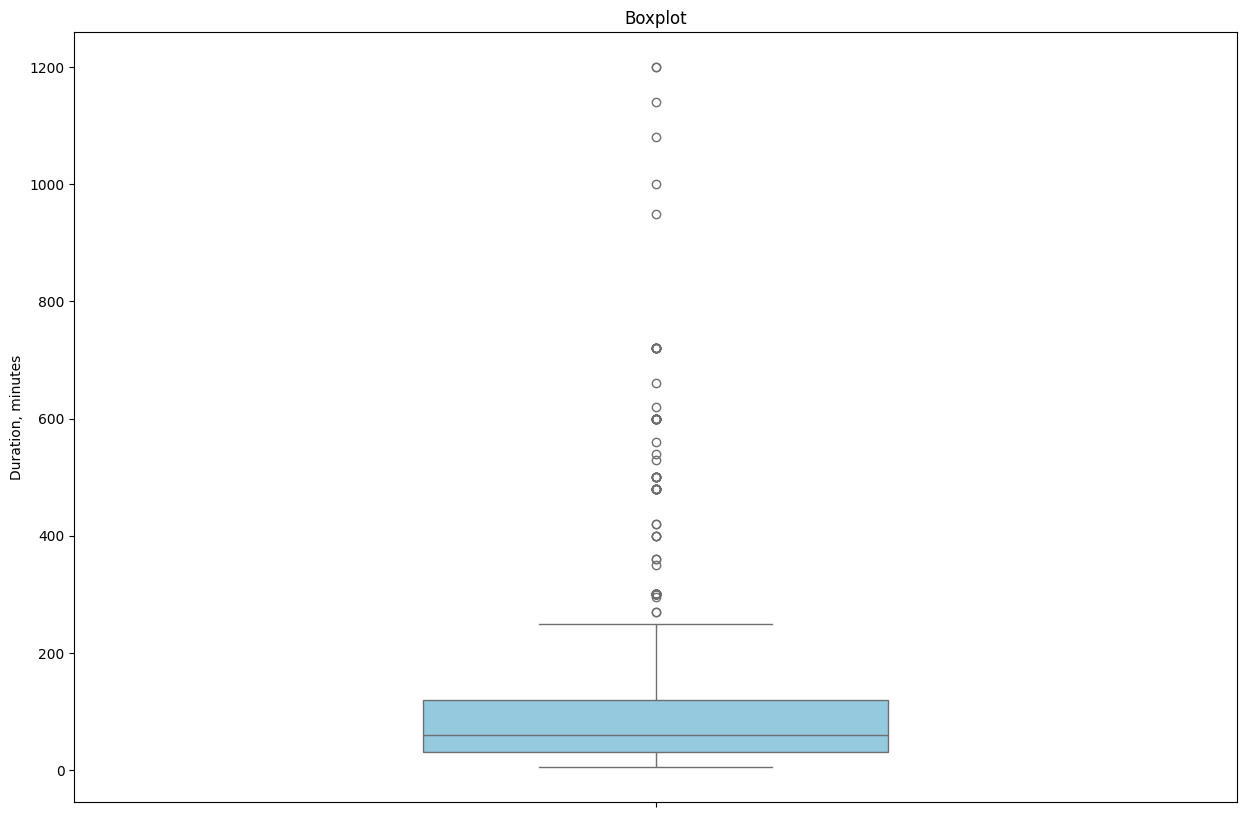

In [55]:
plt.figure(figsize=(15, 10))
sns.boxplot(y=data["duration"].values, width=0.4, color="skyblue")
plt.title("Boxplot")
plt.ylabel("Duration, minutes")

plt.show()

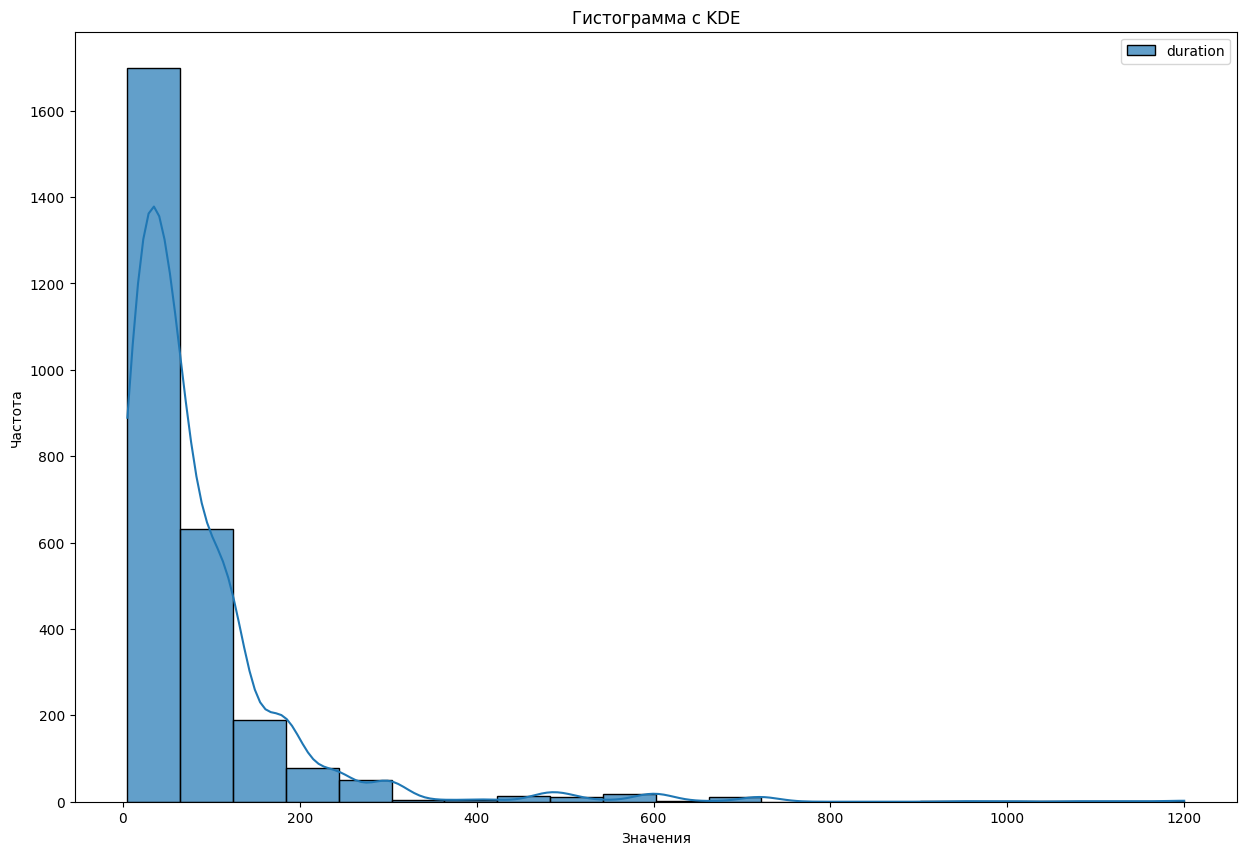

In [56]:
plt.figure(figsize=(15, 10))
sns.histplot(data, bins=20, kde=True, color="skyblue", alpha=0.7)
plt.title("Гистограмма с KDE")
plt.xlabel("Значения")
plt.ylabel("Частота")

plt.show()

### Train / Test / Valid

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data["description"].values, data["duration"].values, test_size=0.15, random_state=21)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1875, random_state=21)

print(f"X_train.shape: {X_train.shape}")
print(f"X_valid.shape: {X_valid.shape}")
print(f"X_test.shape: {X_test.shape}")

X_train.shape: (1875,)
X_valid.shape: (433,)
X_test.shape: (408,)


### TF-IDF

In [58]:
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 5))
vectorizer.fit(X_train)

X_train, X_valid, X_test = vectorizer.transform(X_train), vectorizer.transform(X_valid), vectorizer.transform(X_test)

X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3632 stored elements and shape (1875, 862)>

### Model Fitting

In [59]:
def regression_report(y_true: np.ndarray | pd.Series, y_pred: np.ndarray | pd.Series, model_name: str = ""):
    print(f"\n===== {model_name} =====\n")
    print(f"RMSE: {root_mean_squared_error(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_true, y_pred):.4f}")

In [60]:
models = {"XGBRegressor": XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.3, subsample=1.0, colsample_bytree=1.0, random_state=21, n_jobs=(-1)),
          "Ridge": Ridge(alpha=1.0, max_iter=5000, random_state=21),
          "Lasso": Lasso(alpha=1.0, max_iter=5000, random_state=21),
          "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=5000, random_state=21),
          "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=21, n_jobs=(-1)),
          "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=15, min_samples_split=2, min_samples_leaf=1, random_state=21)
         }

In [61]:
def evaluate_model(model, X_train, X_valid, y_train, y_valid, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    regression_report(y_valid, y_pred, model_name)
    
    return model

In [62]:
trained_models = dict()

for name, model in models.items():
    trained_models[name] = evaluate_model(
        model, X_train, X_valid, y_train, y_valid, name
    )


===== XGBRegressor =====

RMSE: 91.0443
MAE: 54.2913
MAPE: 1.6374

===== Ridge =====

RMSE: 90.0343
MAE: 56.8041
MAPE: 1.5759

===== Lasso =====

RMSE: 90.5942
MAE: 59.5338
MAPE: 1.8328

===== ElasticNet =====

RMSE: 90.5883
MAE: 59.5684
MAPE: 1.8359

===== RandomForestRegressor =====

RMSE: 89.0276
MAE: 56.3460
MAPE: 1.7346

===== DecisionTreeRegressor =====

RMSE: 95.4539
MAE: 58.3975
MAPE: 1.9251


### Hyperparameter optimization

In [63]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [64]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1e3, log=True)

    model = Ridge(alpha=alpha, max_iter=5000, random_state=21)
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="Ridge")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Best params: {'alpha': 2.8036215035430834}
Best score: 55.10647378518409


In [65]:
model = Ridge(alpha=study.best_params["alpha"],
              max_iter=5000, random_state=21)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="Ridge")


===== Ridge =====

RMSE: 120.2616
MAE: 62.6688
MAPE: 1.4983


In [66]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1e3, log=True)

    model = Lasso(alpha=alpha, max_iter=5000, random_state=21)
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="Lasso")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Best params: {'alpha': 0.06889074415952702}
Best score: 55.609182217167586


In [67]:
model = Lasso(alpha=study.best_params["alpha"],
              max_iter=5000, random_state=21)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="Lasso")


===== Lasso =====

RMSE: 124.3620
MAE: 64.2069
MAPE: 1.4080


In [68]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000, random_state=21)
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="ElasticNet")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Best params: {'alpha': 0.0022615842807772483, 'l1_ratio': 0.31774878656649796}
Best score: 55.0899584571612


In [69]:
model = ElasticNet(alpha=study.best_params["alpha"],
                   l1_ratio=study.best_params["l1_ratio"],
                   max_iter=5000, random_state=21)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="ElasticNet")


===== ElasticNet =====

RMSE: 120.2774
MAE: 62.6965
MAPE: 1.5012


In [70]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.65, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    model = XGBRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         gamma=gamma,
                         reg_alpha=reg_alpha,
                         reg_lambda=reg_lambda,
                         random_state=21)
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="XGBRegressor")
study.optimize(objective, n_trials=25, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/25 [00:00<?, ?it/s]

Best params: {'n_estimators': 891, 'max_depth': 3, 'learning_rate': 0.15489341368986, 'subsample': 0.9945994091548505, 'colsample_bytree': 0.6084523216958774, 'gamma': 3.943765834997748, 'reg_alpha': 0.04581856929618766, 'reg_lambda': 8.155816127526288}
Best score: 53.734352111816406


In [71]:
model = XGBRegressor(n_estimators=study.best_params["n_estimators"],
                     max_depth=study.best_params["max_depth"],
                     learning_rate=study.best_params["learning_rate"],
                     subsample=study.best_params["subsample"],
                     colsample_bytree=study.best_params["colsample_bytree"],
                     gamma=study.best_params["gamma"],
                     reg_alpha=study.best_params["reg_alpha"],
                     reg_lambda=study.best_params["reg_lambda"],
                     random_state=21)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="XGBRegressor")


===== XGBRegressor =====

RMSE: 130.0177
MAE: 67.6508
MAPE: 1.5294


In [72]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 30, 500)
    max_depth = trial.suggest_int("max_depth", 3, 25)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 200)

    if min_samples_split < 2 * min_samples_leaf:
        return 1_005_492

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split,
                                  random_state=21, n_jobs=(-1), max_features=None
                                 )
                    
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="RandomForest")
study.optimize(objective, n_trials=25, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/25 [00:00<?, ?it/s]

Best params: {'n_estimators': 325, 'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 96}
Best score: 55.97010945900206


In [73]:
model = RandomForestRegressor(n_estimators=study.best_params["n_estimators"],
                              max_depth=study.best_params["max_depth"],
                              min_samples_leaf=study.best_params["min_samples_leaf"],
                              min_samples_split=study.best_params["min_samples_split"],
                              random_state=21, n_jobs=(-1), max_features=None)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="RandomForest")


===== RandomForest =====

RMSE: 122.7401
MAE: 66.8420
MAPE: 1.6217


In [74]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 25)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 200)

    if min_samples_split < 2 * min_samples_leaf:
        return 1_005_492

    model = DecisionTreeRegressor(
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split,
                                  random_state=21,
                                 )
                    
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="DecisionTree")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Best params: {'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 143}
Best score: 56.668528572923


In [75]:
model = DecisionTreeRegressor(max_depth=study.best_params["max_depth"],
                              min_samples_leaf=study.best_params["min_samples_leaf"],
                              min_samples_split=study.best_params["min_samples_split"],
                              random_state=21, max_features=None)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="DecisionTree")


===== DecisionTree =====

RMSE: 124.7036
MAE: 68.3153
MAPE: 1.7182


Some of models got are overfitted, namely DecisionTreeRegressor (~21%), XGBRegressor(~27%). The rate in brackets shows the relative increase in MAE.

The best model in terms of `MAPE` and `MAE` is `Lasso`, its scores are `RMSE: 124.3993`, `MAE: 64.2091` `MAPE: 1.4064`.

In addition, other linear models have good metrics as well. This is due to the TF-IDF approach, which is fully suitable for weights of models.

In [76]:
del X_train, X_valid, X_test, y_train, y_valid, y_test

### Import data

In [77]:
real_data = pd.read_csv("./data/data.csv", header=0)
fake_data = pd.read_csv("./data/fake_data.csv", header=0)

data = pd.concat([real_data, fake_data], axis=0, ignore_index=True)
del real_data, fake_data
data.drop(["classes"], inplace=True, axis=1)

data

,description,duration
0,Разметить данные,20160
1,Сделать ТАУ,60
2,Сходить в магазин за продуктами,45
3,Сходить в магазин,120
4,Приготовить обед,90
...,...,...
2814,Записаться на йогу,20
2815,Сходить в океанариум,120
2816,Купить новый шарф,30
2817,Погулять в парке с семьей,90


### Delete outliers

In [78]:
target = data["duration"].values
mask_1, mask_2 = target > np.quantile(target, 0.98), target < np.quantile(target, 0.04)
idxs = np.concatenate([np.where(mask_1)[0], np.where(mask_2)[0]], axis=0)

data.drop(labels=idxs, inplace=True)
data.reset_index(inplace=True, drop=True)

data

,description,duration
0,Сделать ТАУ,60
1,Сходить в магазин за продуктами,45
2,Сходить в магазин,120
3,Приготовить обед,90
4,Погулять с собакой,30
...,...,...
2711,Записаться на йогу,20
2712,Сходить в океанариум,120
2713,Купить новый шарф,30
2714,Погулять в парке с семьей,90


### Transform data

In [100]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

model.eval()

def get_sentence_embedding(sentence: str) -> np.ndarray:
    """Transform a sentence into the numpy.ndarray"""
    encoded = tokenizer(
        sentence,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )

    with torch.no_grad():
        outputs = model(**encoded)

    cls_embedding = outputs.last_hidden_state[0, 0]

    return cls_embedding.numpy()

In [80]:
X = np.array([get_sentence_embedding(row) for row in data["description"]])

print(X.shape, X.dtype)

(2716, 312) float32


### X_train / X_valid / X_test

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, data["duration"].values, test_size=0.15, random_state=21)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1875, random_state=21)

print(f"X_train.shape: {X_train.shape}")
print(f"X_valid.shape: {X_valid.shape}")
print(f"X_test.shape: {X_test.shape}")

X_train.shape: (1875, 312)
X_valid.shape: (433, 312)
X_test.shape: (408, 312)


### Data scaling

In [82]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [83]:
X_test.mean(axis=0)[:10]

array([ 0.06632607,  0.07216424, -0.05202985,  0.03159864, -0.03419805,
       -0.07533261,  0.03346777, -0.00055577, -0.01617697,  0.04047656],
      dtype=float32)

### Model Fitting

In [84]:
models = {"XGBRegressor": XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.3, subsample=1.0, colsample_bytree=1.0, random_state=21, n_jobs=(-1)),
          "Ridge": Ridge(alpha=1.0, max_iter=5000, random_state=21),
          "Lasso": Lasso(alpha=1.0, max_iter=5000, random_state=21),
          "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=5000, random_state=21),
          "RandomForestRegressor": RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_split=2, min_samples_leaf=1, max_features=None, random_state=21, n_jobs=(-1)),
          "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=15, min_samples_split=2, min_samples_leaf=1, random_state=21)
         }

In [85]:
trained_models = dict()

for name, model in models.items():
    trained_models[name] = evaluate_model(
        model, X_train, X_valid, y_train, y_valid, name
    )


===== XGBRegressor =====

RMSE: 88.1086
MAE: 56.1112
MAPE: 1.4805

===== Ridge =====

RMSE: 99.1233
MAE: 67.3992
MAPE: 1.7731

===== Lasso =====

RMSE: 87.9700
MAE: 57.7544
MAPE: 1.5790

===== ElasticNet =====

RMSE: 86.4888
MAE: 56.3805
MAPE: 1.5806

===== RandomForestRegressor =====

RMSE: 87.7186
MAE: 56.9514
MAPE: 1.6891

===== DecisionTreeRegressor =====

RMSE: 118.4105
MAE: 69.1731
MAPE: 1.5496


In [86]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [99]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1e3, log=True)

    model = Ridge(alpha=alpha, max_iter=10000, random_state=21)
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="Ridge")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

/home/zomberep/Desktop/TEMPUS/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.02473e-09): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zomberep/Desktop/TEMPUS/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.28879e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Best params: {'alpha': 998.4514765739841}
Best score: 57.11532974243164


/home/zomberep/Desktop/TEMPUS/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.64383e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zomberep/Desktop/TEMPUS/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.46079e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zomberep/Desktop/TEMPUS/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.0284e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/zomberep/Desktop/TEMPUS/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.0204e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [88]:
model = Ridge(alpha=study.best_params["alpha"],
              max_iter=5000, random_state=21)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="Ridge")


===== Ridge =====

RMSE: 114.6255
MAE: 60.7662
MAPE: 1.2613


In [89]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1e3, log=True)

    model = Lasso(alpha=alpha, max_iter=20000, random_state=21, tol=0.001)
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="Lasso")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Best params: {'alpha': 3.7131406395461113}
Best score: 56.196441650390625


In [90]:
model = Lasso(alpha=study.best_params["alpha"],
              max_iter=5000, random_state=21)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="Lasso")


===== Lasso =====

RMSE: 116.3084
MAE: 62.4773
MAPE: 1.3768


In [91]:
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 1e3, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=25000, random_state=21)
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="ElasticNet")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Best params: {'alpha': 2.837265946711477, 'l1_ratio': 0.24677997028673881}
Best score: 55.554325103759766


/home/zomberep/Desktop/TEMPUS/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.959e+03, tolerance: 2.066e+03
  model = cd_fast.enet_coordinate_descent(


In [92]:
model = ElasticNet(alpha=study.best_params["alpha"],
                   l1_ratio=study.best_params["l1_ratio"],
                   max_iter=5000, random_state=21)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="ElasticNet")


===== ElasticNet =====

RMSE: 115.6773
MAE: 60.9665
MAPE: 1.3599


In [93]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.65, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 10)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 10)

    model = XGBRegressor(n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         gamma=gamma,
                         reg_alpha=reg_alpha,
                         reg_lambda=reg_lambda,
                         random_state=21)
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="XGBRegressor")
study.optimize(objective, n_trials=25, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/25 [00:00<?, ?it/s]

Best params: {'n_estimators': 151, 'max_depth': 7, 'learning_rate': 0.03324923879067669, 'subsample': 0.8148271198636703, 'colsample_bytree': 0.6856289764504443, 'gamma': 2.1327709755720665, 'reg_alpha': 0.8378431394740093, 'reg_lambda': 6.239049621014768}
Best score: 53.34424591064453


In [94]:
model = XGBRegressor(n_estimators=study.best_params["n_estimators"],
                     max_depth=study.best_params["max_depth"],
                     learning_rate=study.best_params["learning_rate"],
                     subsample=study.best_params["subsample"],
                     colsample_bytree=study.best_params["colsample_bytree"],
                     gamma=study.best_params["gamma"],
                     reg_alpha=study.best_params["reg_alpha"],
                     reg_lambda=study.best_params["reg_lambda"],
                     random_state=21)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="XGBRegressor")


===== XGBRegressor =====

RMSE: 115.5049
MAE: 58.6507
MAPE: 1.2265


In [95]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 30, 500)
    max_depth = trial.suggest_int("max_depth", 3, 25)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 200)

    if min_samples_split < 2 * min_samples_leaf:
        return 1_005_492

    model = RandomForestRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split,
                                  random_state=21, n_jobs=(-1), max_features=None
                                 )
                    
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="RandomForest")
study.optimize(objective, n_trials=25, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")


  0%|          | 0/25 [00:00<?, ?it/s]

Best params: {'n_estimators': 180, 'max_depth': 16, 'min_samples_leaf': 11, 'min_samples_split': 55}
Best score: 56.063073351165826


In [96]:
model = RandomForestRegressor(n_estimators=study.best_params["n_estimators"],
                              max_depth=study.best_params["max_depth"],
                              min_samples_leaf=study.best_params["min_samples_leaf"],
                              min_samples_split=study.best_params["min_samples_split"],
                              random_state=21, n_jobs=(-1), max_features=None)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="RandomForest")


===== RandomForest =====

RMSE: 116.9012
MAE: 61.4874
MAPE: 1.3917


In [97]:
def objective(trial):
    max_depth = trial.suggest_int("max_depth", 3, 25)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 200)

    if min_samples_split < 2 * min_samples_leaf:
        return 1_005_492

    model = DecisionTreeRegressor(
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf,
                                  min_samples_split=min_samples_split,
                                  random_state=21,
                                 )
                    
    model.fit(X_train, y_train)

    score = mean_absolute_error(y_valid, model.predict(X_valid))

    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=21), study_name="DecisionTree")
study.optimize(objective, n_trials=100, show_progress_bar=True, n_jobs=(-1))

print(f"Best params: {study.best_params}")
print(f"Best score: {study.best_value}")

  0%|          | 0/100 [00:00<?, ?it/s]

Best params: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 77}
Best score: 58.35601846701444


In [98]:
model = DecisionTreeRegressor(max_depth=study.best_params["max_depth"],
                              min_samples_leaf=study.best_params["min_samples_leaf"],
                              min_samples_split=study.best_params["min_samples_split"],
                              random_state=21, max_features=None)
model.fit(X_train, y_train)

regression_report(y_true=y_test, y_pred=model.predict(X_test), model_name="DecisionTree")


===== DecisionTree =====

RMSE: 127.1097
MAE: 70.0591
MAPE: 1.7424


Due to the use of the embeddings no models are overfitted.

The best model in terms of `MAPE` and `MAE` is XGBRegressor, its scores are `RMSE: 116.8466`, `MAE: 59.8844`, `MAPE: 1.2367`.

Ridge deserves to be mentioned because is has close metrics to the XBGRegressor. Other models have slightly worse results.

Thus, for the regression problem the best the model to use is **XGBRegressor**, that was fitted using **embeddings**.